In [ ]:
import numpy as np


def sample_qprime(q, alpha, rng):
    # Invert Sudakov: Delta(q'|q) = exp(-alpha/2 * (ln^2(1/q') - ln^2(1/q)))
    r = rng.random()
    L = np.log(1.0 / q)
    Lp = np.sqrt(L * L - (2.0 / alpha) * np.log(r))
    return np.exp(-Lp)


def sample_zprime(z, qprime, rng):
    # z' = z * (1 - (q')^r2), r2 ~ U(0,1)
    r2 = rng.random()
    return z * (1.0 - (qprime ** r2))


def run_cascade(alpha=0.2, mu=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    q = 1.0
    z = 1.0
    mult = 0

    while q > mu:
        qprime = sample_qprime(q, alpha, rng)

        if qprime <= mu:
            return z, mult

        zprime = sample_zprime(z, qprime, rng)
        q, z = qprime, zprime
        mult += 1

    return z, mult


def simulate(alpha=0.2, mu=0.01, n_events=10000, seed=12345):
    rng = np.random.default_rng(seed)

    z_final = np.empty(n_events, dtype=float)
    mult = np.empty(n_events, dtype=int)

    for i in range(n_events):
        zf, m = run_cascade(alpha=alpha, mu=mu, rng=rng)
        z_final[i] = zf
        mult[i] = m

    mean_z = z_final.mean()
    var_z = z_final.var(ddof=1)

    return {
        "alpha": alpha,
        "mu": mu,
        "n_events": n_events,
        "mean_z_final": mean_z,
        "var_z_final": var_z,
        "mult_mean": mult.mean(),
        "mult_var": mult.var(ddof=1),
        "mult_hist": np.bincount(mult),
    }


if __name__ == "__main__":
    for mu in [0.1, 0.03, 0.01, 0.003]:
        out = simulate(alpha=0.2, mu=mu, n_events=20000, seed=1)
        print(
            f"mu={out['mu']:.3g}  <z>={out['mean_z_final']:.5f}  "
            f"Var(z)={out['var_z_final']:.5e}  <mult>={out['mult_mean']:.3f}"
        )

mu=0.1  <z>=0.75880  Var(z)=1.11732e-01  <mult>=0.524
mu=0.03  <z>=0.60035  Var(z)=1.26962e-01  <mult>=1.226
mu=0.01  <z>=0.48875  Var(z)=1.19562e-01  <mult>=2.114
mu=0.003  <z>=0.38069  Var(z)=1.01737e-01  <mult>=3.380


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_qprime(q, alpha, rng):
    """
    Sample q' from the Sudakov survival Delta(q'|q).
    We solve r = Delta(q'|q) for q'.
    """
    r = rng.random()  # uniform random number in (0,1)

    # L = ln(1/q) is a convenient variable (always >= 0 for q in (0,1])
    L = np.log(1.0 / q)

    # From inversion: L'^2 = L^2 - (2/alpha)*ln(r)
    # Note: ln(r) is negative, so the term - (2/alpha)*ln(r) is positive.
    Lp = np.sqrt(L * L - (2.0 / alpha) * np.log(r))

    # q' = exp(-L')
    return np.exp(-Lp)


def sample_zprime(z, qprime, rng):
    """
    Sample z' from p(z'|z,q') ∝ 1/(z - z') on (0, z(1-q')).
    Inversion gives z' = z * (1 - (q')^r2).
    """
    r2 = rng.random()  # uniform in (0,1)
    return z * (1.0 - (qprime ** r2))


def run_one_event(alpha, mu, rng):
    """
    Simulate one cascade event starting at (q,z)=(1,1).
    Returns final z and multiplicity m (# of emissions).
    """
    q = 1.0
    z = 1.0
    m = 0

    # We evolve downward in q until we fall below mu.
    while q > mu:
        qprime = sample_qprime(q, alpha, rng)

        # If the next emission scale is below cutoff,
        # we stop and return current z (no more emissions resolved).
        if qprime <= mu:
            return z, m

        # Otherwise an emission happens:
        # sample the post-emission momentum fraction z'
        zprime = sample_zprime(z, qprime, rng)

        # Update the state -> Markov step
        q, z = qprime, zprime
        m += 1

    return z, m


def simulate(alpha=0.2, mu=0.01, n_events=20000, seed=1):
    rng = np.random.default_rng(seed)

    z_final = np.empty(n_events, dtype=float)
    mult = np.empty(n_events, dtype=int)

    for i in range(n_events):
        z_final[i], mult[i] = run_one_event(alpha, mu, rng)

    return z_final, mult

def analyze_and_plot(z_final, mult, mu, bins_z=60):
    # --- z_final histogram
    plt.figure()
    plt.hist(z_final, bins=bins_z, density=True)
    plt.xlabel(r"$z_{\mathrm{final}}$")
    plt.ylabel("density")
    plt.title(f"Final momentum fraction, mu={mu}")
    plt.grid(True)

    # --- multiplicity histogram
    plt.figure()
    mmax = int(mult.max())
    plt.hist(mult, bins=np.arange(mmax + 2) - 0.5, density=True)
    plt.xlabel("multiplicity m")
    plt.ylabel("probability")
    plt.title(f"Multiplicity distribution, mu={mu}")
    plt.grid(True)

    # --- print key numbers
    mean_z = z_final.mean()
    var_z = z_final.var(ddof=1)
    mean_m = mult.mean()
    var_m = mult.var(ddof=1)

    print(f"mu = {mu}")
    print(f"<z_final> = {mean_z:.6f}")
    print(f"Var(z_final) = {var_z:.6e}")
    print(f"<m> = {mean_m:.6f}")
    print(f"Var(m) = {var_m:.6e}")


def scan_mu(alpha=0.2, mu_list=(0.1, 0.03, 0.01, 0.003), n_events=20000, seed=1):
    from math import log10

    mus = []
    mean_zs = []
    var_zs = []
    mean_ms = []

    for mu in mu_list:
        z_final, mult = simulate(alpha=alpha, mu=mu, n_events=n_events, seed=seed)
        analyze_and_plot(z_final, mult, mu)

        mus.append(mu)
        mean_zs.append(z_final.mean())
        var_zs.append(z_final.var(ddof=1))
        mean_ms.append(mult.mean())

    # --- summary plots vs mu
    mus = np.array(mus)
    mean_zs = np.array(mean_zs)
    var_zs = np.array(var_zs)
    mean_ms = np.array(mean_ms)

    plt.figure()
    plt.plot(mus, mean_zs, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle z_{\mathrm{final}}\rangle$")
    plt.title("Mean final momentum vs mu")
    plt.grid(True)

    plt.figure()
    plt.plot(mus, var_zs, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\mathrm{Var}(z_{\mathrm{final}})$")
    plt.title("Variance of final momentum vs mu")
    plt.grid(True)

    plt.figure()
    plt.plot(mus, mean_ms, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle m\rangle$")
    plt.title("Mean multiplicity vs mu")
    plt.grid(True)

    plt.show()

mu = 0.1
<z_final> = 0.756609
Var(z_final) = 1.119432e-01
<m> = 0.529300
Var(m) = 5.349683e-01


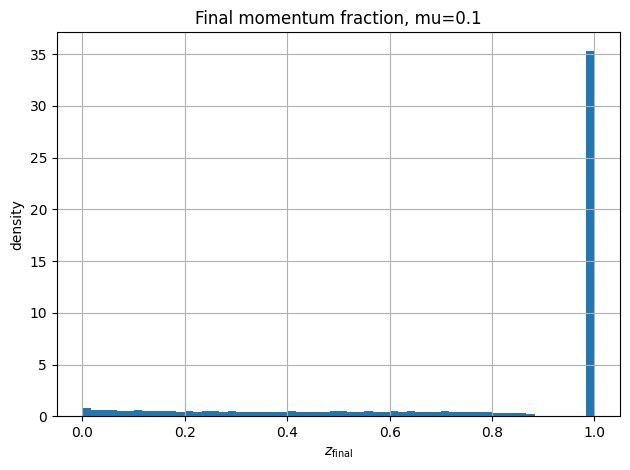

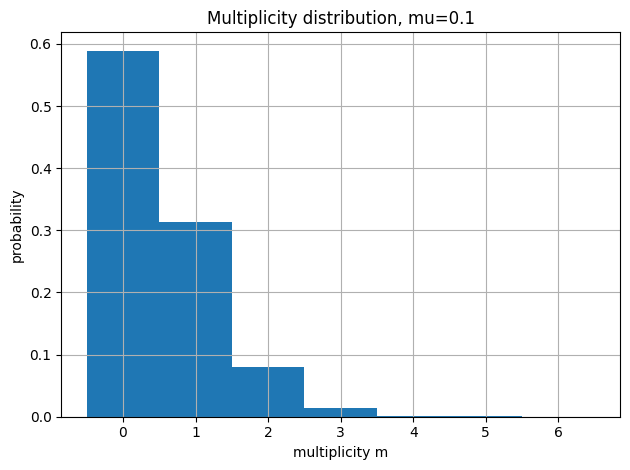

mu = 0.03
<z_final> = 0.599968
Var(z_final) = 1.279874e-01
<m> = 1.234800
Var(m) = 1.238031e+00


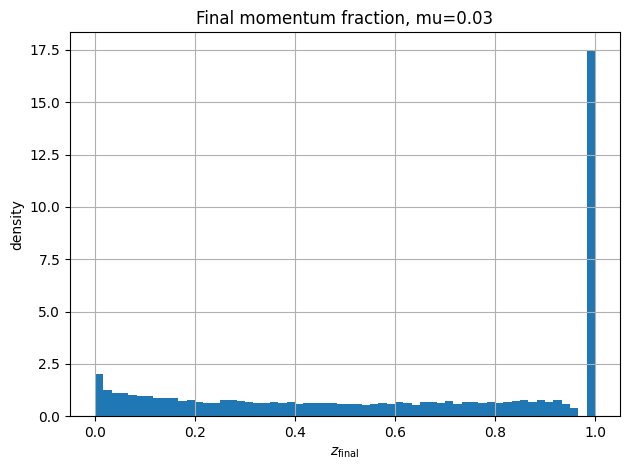

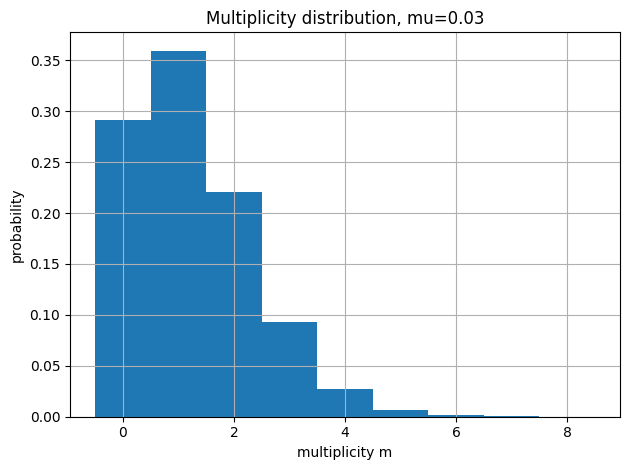

mu = 0.01
<z_final> = 0.482935
Var(z_final) = 1.189434e-01
<m> = 2.127800
Var(m) = 2.125473e+00


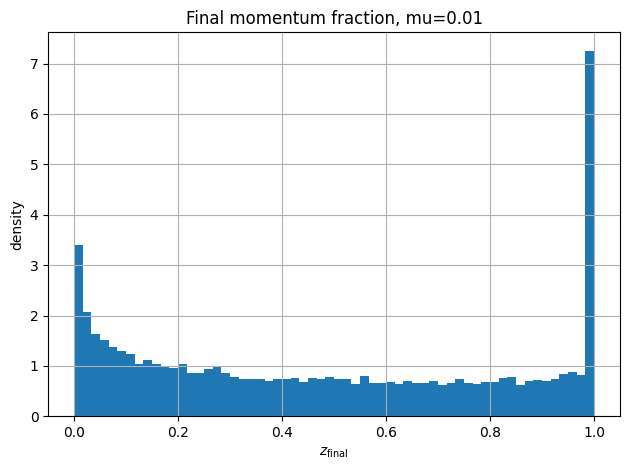

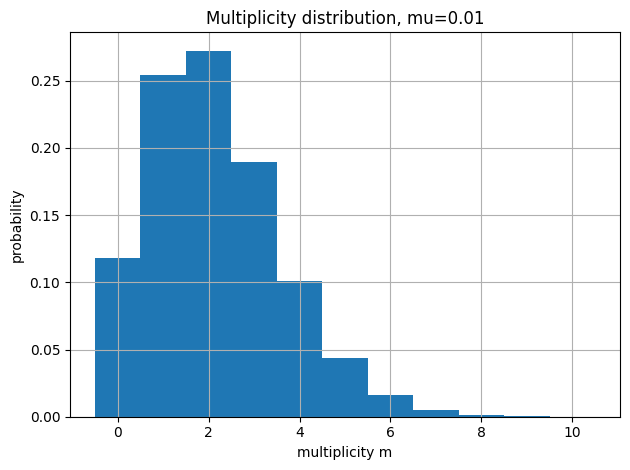

mu = 0.003
<z_final> = 0.385024
Var(z_final) = 1.015395e-01
<m> = 3.365950
Var(m) = 3.336397e+00


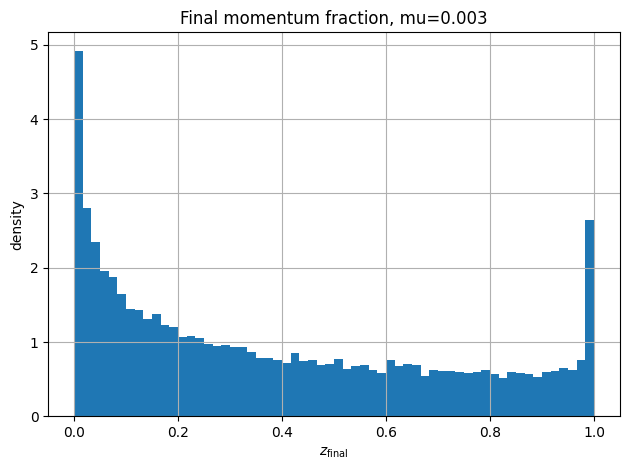

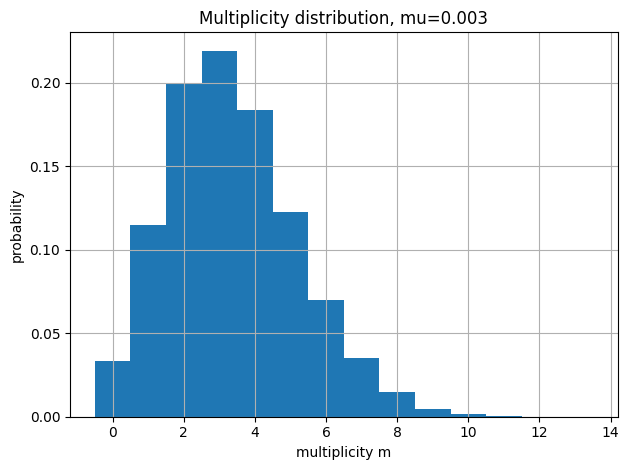

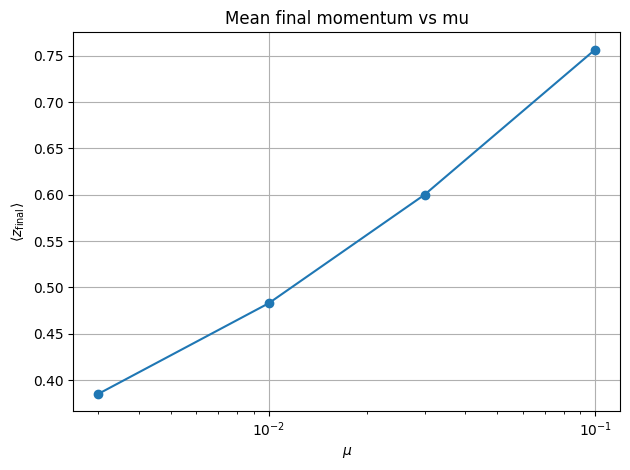

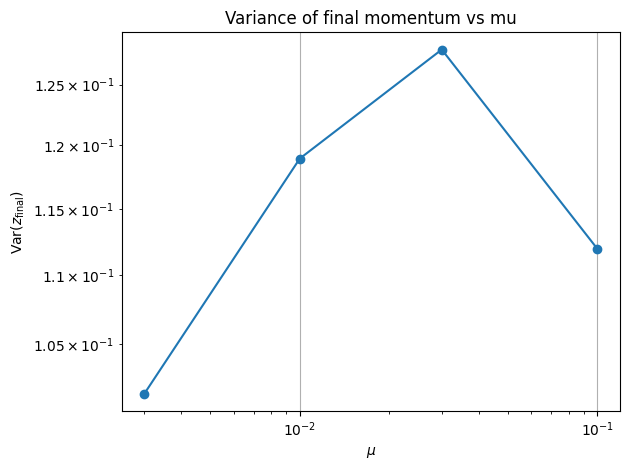

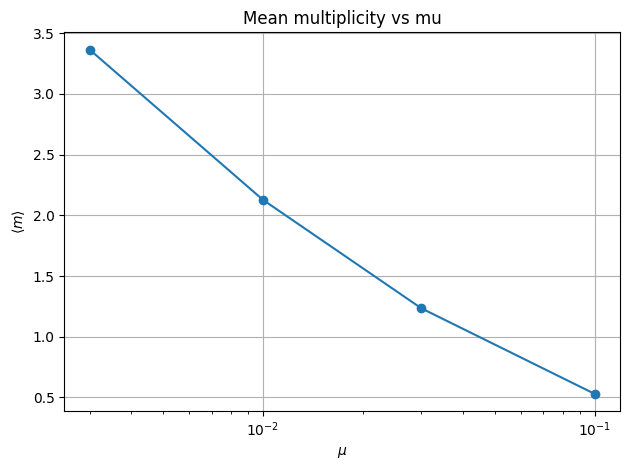

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def _u01_open(rng):
    """
    Uniform in (0,1), but never exactly 0 or 1.
    Prevents log(0) and related issues.
    """
    r = rng.random()
    # push away from 0 and 1 if needed
    if r == 0.0:
        r = np.nextafter(0.0, 1.0)
    elif r == 1.0:
        r = np.nextafter(1.0, 0.0)
    return r


def sample_qprime(q, alpha, rng):
    """
    Sample q' from Sudakov Delta(q'|q) by inversion.

    Delta(q'|q) = exp[-alpha/2 * (ln^2(1/q') - ln^2(1/q))]
    Set r = Delta and solve for q'.
    """
    r = _u01_open(rng)

    L = np.log(1.0 / q)  # L = ln(1/q) >= 0

    # L'^2 = L^2 - (2/alpha) ln(r)
    Lp2 = L * L - (2.0 / alpha) * np.log(r)
    Lp = np.sqrt(Lp2)

    # q' = exp(-L')
    return np.exp(-Lp)


def sample_zprime(z, qprime, rng):
    """
    Sample z' from p(z'|z,q') ∝ 1/(z - z') on 0 < z' < z(1-q').

    Inversion gives: z' = z * (1 - (q')^r2), r2 ~ U(0,1).
    """
    r2 = _u01_open(rng)
    return z * (1.0 - (qprime ** r2))


def run_one_event(alpha, mu, rng):
    """
    Simulate one cascade event starting at (q,z)=(1,1).
    Returns final z and multiplicity m (# emissions).
    """
    q = 1.0
    z = 1.0
    m = 0

    while True:
        qprime = sample_qprime(q, alpha, rng)

        # cutoff: no resolved emission below mu
        if qprime <= mu:
            return z, m

        # emission happens
        zprime = sample_zprime(z, qprime, rng)

        q, z = qprime, zprime
        m += 1


def simulate(alpha=0.2, mu=0.01, n_events=20000, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    z_final = np.empty(n_events, dtype=float)
    mult = np.empty(n_events, dtype=int)

    for i in range(n_events):
        z_final[i], mult[i] = run_one_event(alpha, mu, rng)

    return z_final, mult


def analyze_and_plot(z_final, mult, mu, bins_z=60, show=True):
    # z_final histogram
    plt.figure()
    plt.hist(z_final, bins=bins_z, density=True)
    plt.xlabel(r"$z_{\mathrm{final}}$")
    plt.ylabel("density")
    plt.title(f"Final momentum fraction, mu={mu}")
    plt.grid(True)
    plt.tight_layout()

    # multiplicity histogram
    plt.figure()
    mmax = int(mult.max())
    bins = np.arange(mmax + 2) - 0.5  # centers at integers
    plt.hist(mult, bins=bins, density=True)
    plt.xlabel("multiplicity m")
    plt.ylabel("probability")
    plt.title(f"Multiplicity distribution, mu={mu}")
    plt.grid(True)
    plt.tight_layout()

    # summary numbers
    mean_z = float(z_final.mean())
    var_z = float(z_final.var(ddof=1))
    mean_m = float(mult.mean())
    var_m = float(mult.var(ddof=1))

    print(f"mu = {mu}")
    print(f"<z_final> = {mean_z:.6f}")
    print(f"Var(z_final) = {var_z:.6e}")
    print(f"<m> = {mean_m:.6f}")
    print(f"Var(m) = {var_m:.6e}")

    if show:
        plt.show()
    else:
        # optional: close to avoid too many open figures in long runs
        plt.close("all")


def scan_mu(alpha=0.2, mu_list=(0.1, 0.03, 0.01, 0.003), n_events=20000, seed=1):
    base_rng = np.random.default_rng(seed)

    mus = np.array(mu_list, dtype=float)
    mean_zs = np.empty(len(mus), dtype=float)
    var_zs = np.empty(len(mus), dtype=float)
    mean_ms = np.empty(len(mus), dtype=float)

    for i, mu in enumerate(mus):
        # independent RNG stream per mu (важно для честного сравнения)
        rng = np.random.default_rng(base_rng.integers(0, 2**32 - 1))

        z_final, mult = simulate(alpha=alpha, mu=mu, n_events=n_events, rng=rng)
        analyze_and_plot(z_final, mult, mu, bins_z=60, show=True)

        mean_zs[i] = z_final.mean()
        var_zs[i] = z_final.var(ddof=1)
        mean_ms[i] = mult.mean()

    # summary plots vs mu
    plt.figure()
    plt.plot(mus, mean_zs, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle z_{\mathrm{final}}\rangle$")
    plt.title("Mean final momentum vs mu")
    plt.grid(True)
    plt.tight_layout()

    plt.figure()
    plt.plot(mus, var_zs, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\mathrm{Var}(z_{\mathrm{final}})$")
    plt.title("Variance of final momentum vs mu")
    plt.grid(True)
    plt.tight_layout()

    plt.figure()
    plt.plot(mus, mean_ms, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle m\rangle$")
    plt.title("Mean multiplicity vs mu")
    plt.grid(True)
    plt.tight_layout()

    plt.show()


# --- RUN:
scan_mu(alpha=0.2, mu_list=(0.1, 0.03, 0.01, 0.003), n_events=20000, seed=1)

mu = 0.1
<z_final> = 0.758803
Var(z_final) = 1.117317e-01
<m> = 0.523750
Var(m) = 5.265623e-01
mu = 0.03
<z_final> = 0.600346
Var(z_final) = 1.269622e-01
<m> = 1.225950
Var(m) = 1.215457e+00
mu = 0.01
<z_final> = 0.488753
Var(z_final) = 1.195616e-01
<m> = 2.113900
Var(m) = 2.144834e+00
mu = 0.003
<z_final> = 0.380693
Var(z_final) = 1.017367e-01
<m> = 3.379550
Var(m) = 3.378161e+00


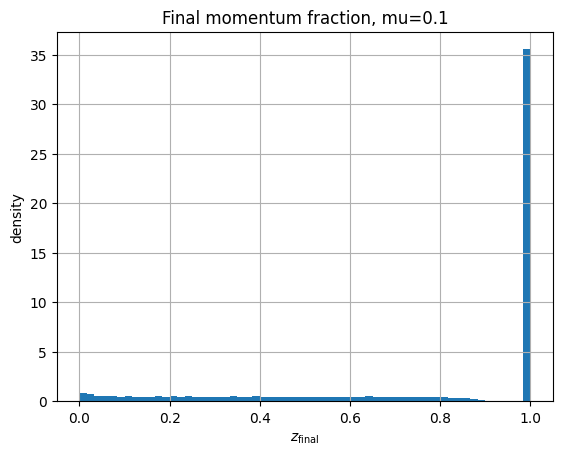

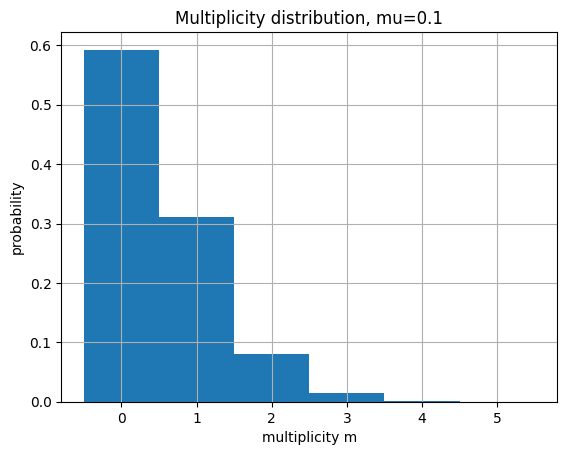

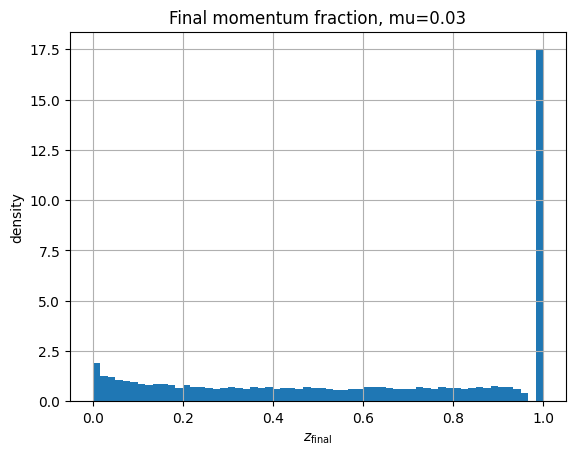

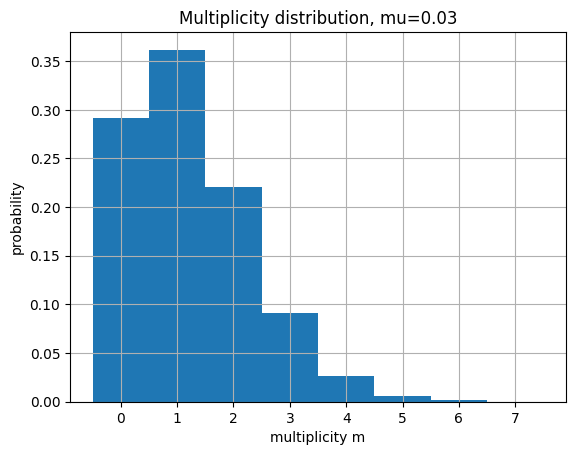

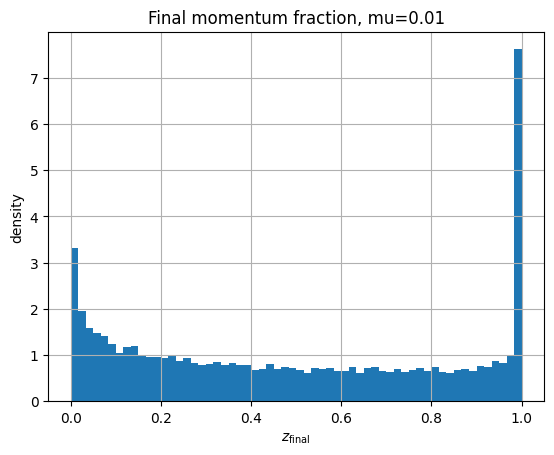

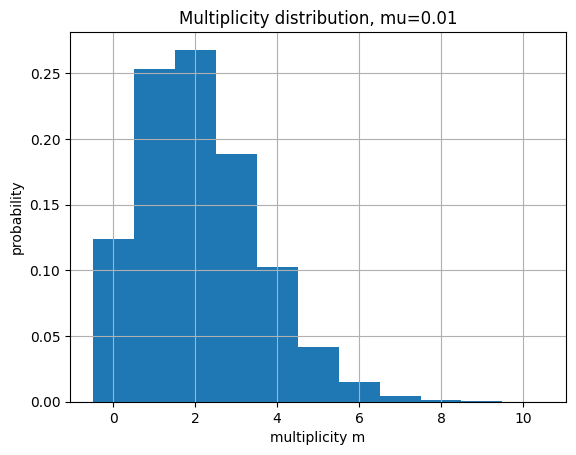

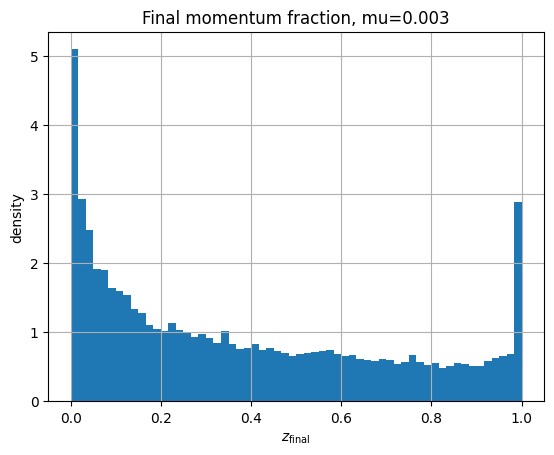

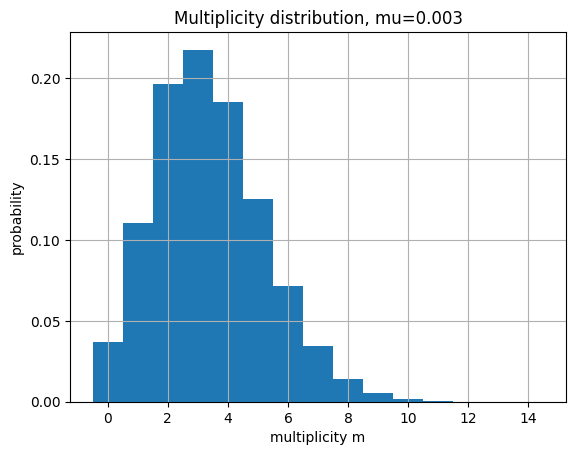

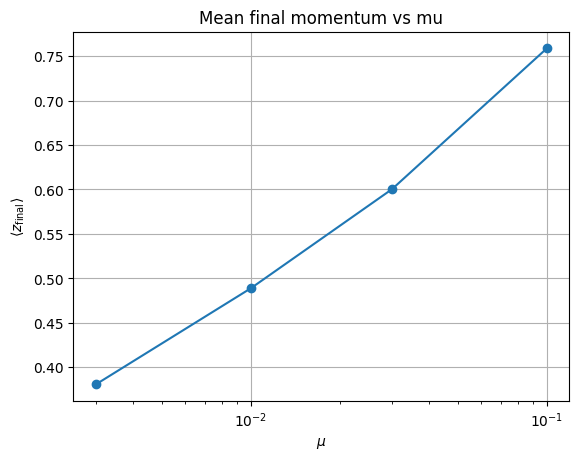

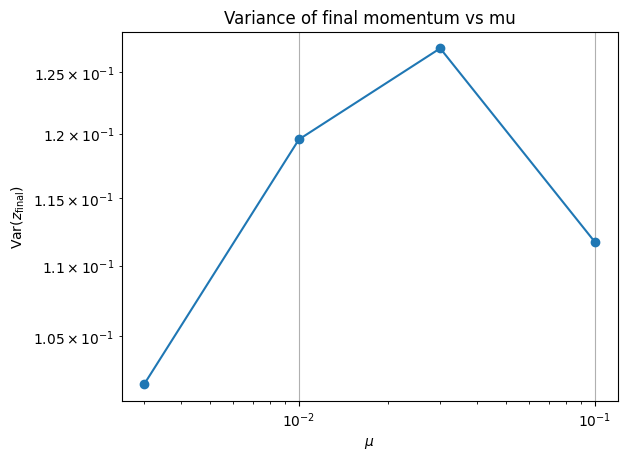

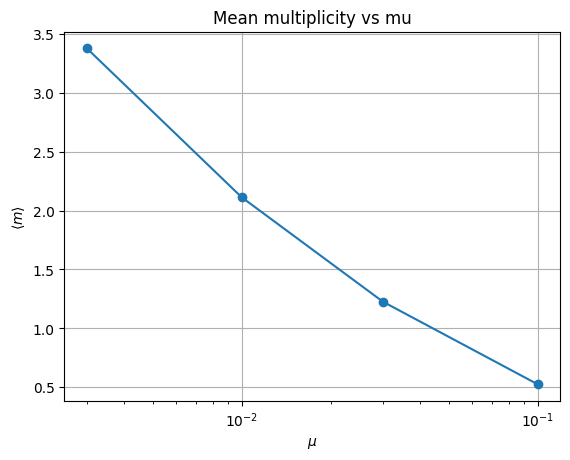

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_qprime(q, alpha, rng):
    """
    Sample q' from the Sudakov survival Delta(q'|q).
    We solve r = Delta(q'|q) for q'.
    """
    r = rng.random()  # uniform random number in (0,1)

    # L = ln(1/q) is a convenient variable (always >= 0 for q in (0,1])
    L = np.log(1.0 / q)

    # From inversion: L'^2 = L^2 - (2/alpha)*ln(r)
    # Note: ln(r) is negative, so the term - (2/alpha)*ln(r) is positive.
    Lp = np.sqrt(L * L - (2.0 / alpha) * np.log(r))

    # q' = exp(-L')
    return np.exp(-Lp)


def sample_zprime(z, qprime, rng):
    """
    Sample z' from p(z'|z,q') ∝ 1/(z - z') on (0, z(1-q')).
    Inversion gives z' = z * (1 - (q')^r2).
    """
    r2 = rng.random()  # uniform in (0,1)
    return z * (1.0 - (qprime ** r2))


def run_one_event(alpha, mu, rng):
    """
    Simulate one cascade event starting at (q,z)=(1,1).
    Returns final z and multiplicity m (# of emissions).
    """
    q = 1.0
    z = 1.0
    m = 0

    # We evolve downward in q until we fall below mu.
    while q > mu:
        qprime = sample_qprime(q, alpha, rng)

        # If the next emission scale is below cutoff,
        # we stop and return current z (no more emissions resolved).
        if qprime <= mu:
            return z, m

        # Otherwise an emission happens:
        # sample the post-emission momentum fraction z'
        zprime = sample_zprime(z, qprime, rng)

        # Update the state -> Markov step
        q, z = qprime, zprime
        m += 1

    return z, m


def simulate(alpha=0.2, mu=0.01, n_events=20000, seed=1):
    rng = np.random.default_rng(seed)

    z_final = np.empty(n_events, dtype=float)
    mult = np.empty(n_events, dtype=int)

    for i in range(n_events):
        z_final[i], mult[i] = run_one_event(alpha, mu, rng)

    return z_final, mult

def analyze_and_plot(z_final, mult, mu, bins_z=60):
    # --- z_final histogram
    plt.figure()
    plt.hist(z_final, bins=bins_z, density=True)
    plt.xlabel(r"$z_{\mathrm{final}}$")
    plt.ylabel("density")
    plt.title(f"Final momentum fraction, mu={mu}")
    plt.grid(True)

    # --- multiplicity histogram
    plt.figure()
    mmax = int(mult.max())
    plt.hist(mult, bins=np.arange(mmax + 2) - 0.5, density=True)
    plt.xlabel("multiplicity m")
    plt.ylabel("probability")
    plt.title(f"Multiplicity distribution, mu={mu}")
    plt.grid(True)

    # --- print key numbers
    mean_z = z_final.mean()
    var_z = z_final.var(ddof=1)
    mean_m = mult.mean()
    var_m = mult.var(ddof=1)

    print(f"mu = {mu}")
    print(f"<z_final> = {mean_z:.6f}")
    print(f"Var(z_final) = {var_z:.6e}")
    print(f"<m> = {mean_m:.6f}")
    print(f"Var(m) = {var_m:.6e}")


def scan_mu(alpha=0.2, mu_list=(0.1, 0.03, 0.01, 0.003), n_events=20000, seed=1):
    from math import log10

    mus = []
    mean_zs = []
    var_zs = []
    mean_ms = []

    for mu in mu_list:
        z_final, mult = simulate(alpha=alpha, mu=mu, n_events=n_events, seed=seed)
        analyze_and_plot(z_final, mult, mu)

        mus.append(mu)
        mean_zs.append(z_final.mean())
        var_zs.append(z_final.var(ddof=1))
        mean_ms.append(mult.mean())

    # --- summary plots vs mu
    mus = np.array(mus)
    mean_zs = np.array(mean_zs)
    var_zs = np.array(var_zs)
    mean_ms = np.array(mean_ms)

    plt.figure()
    plt.plot(mus, mean_zs, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle z_{\mathrm{final}}\rangle$")
    plt.title("Mean final momentum vs mu")
    plt.grid(True)

    plt.figure()
    plt.plot(mus, var_zs, marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\mathrm{Var}(z_{\mathrm{final}})$")
    plt.title("Variance of final momentum vs mu")
    plt.grid(True)

    plt.figure()
    plt.plot(mus, mean_ms, marker="o")
    plt.xscale("log")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\langle m\rangle$")
    plt.title("Mean multiplicity vs mu")
    plt.grid(True)

    plt.show()

if __name__ == "__main__":
    scan_mu()